# Association Rules Mining For Item Pairs

Association analysis using the apriori algorithm to derive rules of the form {A} -> {B}. Using instacarts retail set.

Content largely taken from this excellent [blogpost](https://www.datatheque.com/posts/association-analysis/) by Grace Tenorio.


**Data Sources:**

- `data/instacart/order_products__prior.csv`: 32 Mio. instances of order_id and product_id combinations
- `data/instacart/products.csv`: Product info, I need this in the very last part to add the product names only.

**Changes**

- 2019-07-04: Start and complete notebook


<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Import-libraries,-load-data" data-toc-modified-id="Import-libraries,-load-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Import libraries, load data</a></span></li><li><span><a href="#Check-basic-data-structure" data-toc-modified-id="Check-basic-data-structure-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Check basic data structure</a></span></li><li><span><a href="#Perpare-data" data-toc-modified-id="Perpare-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Perpare data</a></span></li><li><span><a href="#Define-Association-rules-function" data-toc-modified-id="Define-Association-rules-function-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Define Association rules function</a></span><ul class="toc-item"><li><span><a href="#Helper-functions-to-the-main-association-rules-function" data-toc-modified-id="Helper-functions-to-the-main-association-rules-function-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Helper functions to the main association rules function</a></span></li><li><span><a href="#Association-rules-function" data-toc-modified-id="Association-rules-function-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Association rules function</a></span></li></ul></li><li><span><a href="#Perform-Association-rules-mining" data-toc-modified-id="Perform-Association-rules-mining-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Perform Association rules mining</a></span><ul class="toc-item"><li><span><a href="#Replace-Product-IDs-with-Names" data-toc-modified-id="Replace-Product-IDs-with-Names-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Replace Product IDs with Names</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Conclusion</a></span></li></ul></li></ul></div>

---

## Import libraries, load data

In [1]:
# Import libraries
import numpy as np
import pandas as pd
from tqdm import tqdm

# Specials
from itertools import combinations, groupby
from collections import Counter

# My functions
import EDA_functions as EDA
import cleaning_functions as cleaning

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns 
# sns.set_style('whitegrid')
color = 'rebeccapurple'
%matplotlib inline

# Display settings
from IPython.display import display
pd.options.display.max_columns = 100

In [12]:
# Load data
orders_df = pd.read_csv('data/instacart/order_products__prior.csv')
item_name   = pd.read_csv('data/instacart/products.csv')

## Check basic data structure

In [3]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 4 columns):
order_id             int64
product_id           int64
add_to_cart_order    int64
reordered            int64
dtypes: int64(4)
memory usage: 989.8 MB


In [4]:
orders_df.sample(10)

,order_id,product_id,add_to_cart_order,reordered
21714746,2290485,27937,1,0
1302103,137360,48765,10,0
144301,15191,30597,1,1
17277787,1822511,35042,5,1
1392741,146899,48189,3,0
16553251,1746131,37067,13,0
27250875,2873561,7912,3,0
29918653,3155663,36107,5,0
15639026,1650011,44422,1,1
9213754,972502,42265,2,1


In [5]:
print("Number of unique orders: ", orders_df['order_id'].nunique())
print("Number of unique products: ", orders_df['product_id'].nunique())
print("Mean number of products per order: ", round(len(orders_df) / orders_df['order_id'].nunique(),0))

Number of unique orders:  3214874
Number of unique products:  49677
Mean number of products per order:  10.0


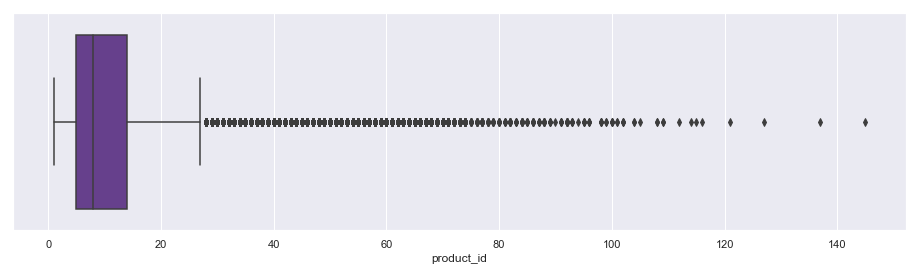

In [6]:
"""Visualize distribution of number of products per order"""
order_sizes = orders_df.groupby('order_id')['product_id'].count()
plt.figure(figsize=(16,4))
sns.boxplot(order_sizes, color=color, orient='h');

## Perpare data

Convert order data into format expected by the association rules function

In [7]:
# Convert from DataFrame to a Series, with order_id as index and item_id as value
orders = orders_df.set_index('order_id')['product_id'].rename('item_id')

assert orders.index.nunique() == orders_df['order_id'].nunique()
assert orders.nunique() == orders_df['product_id'].nunique()

# Check results
display(orders.head(10))
type(orders)

order_id
2    33120
2    28985
2     9327
2    45918
2    30035
2    17794
2    40141
2     1819
2    43668
3    33754
Name: item_id, dtype: int64

pandas.core.series.Series

## Define Association rules function

### Helper functions to the main association rules function

In [8]:
def calc_freq(iterable):
    """Return frequency counts for items and item pairs"""
    
    if type(iterable) == pd.core.series.Series:
        return iterable.value_counts().rename("freq")
    else: 
        return pd.Series(Counter(iterable)).rename("freq")

    
    
def order_count(order_item):
    """Return number of unique orders"""
    
    return len(set(order_item.index))



def get_item_pairs(order_item):
    """Return generator that yields item pairs, one at a time"""
    
    order_item = order_item.reset_index().values()
    for order_id, order_object in groupby(order_item, lambda x: x[0]):
        item_list = [item[1] for item in order_object]
              
        for item_pair in combinations(item_list, 2):
            yield item_pair
            


def merge_item_stats(item_pairs, item_stats):
    """Returns frequency and support associated with item"""
    
    return (item_pairs
                .merge(item_stats.rename(
                    columns={'freq': 'freqA', 
                             'support': 'supportA'}), left_on='item_A', right_index=True)
                .merge(item_stats.rename(
                    columns={'freq': 'freqB', 
                             'support': 'supportB'}), left_on='item_B', right_index=True))



def merge_item_name(rules, item_name):
    """Return name associated with item"""
    
    columns = ['itemA','itemB','freqAB','supportAB','freqA','supportA','freqB','supportB', 
               'confidenceAtoB','confidenceBtoA','lift']
    rules = (rules
                .merge(item_name.rename(columns={'item_name': 'itemA'}), 
                       left_on='item_A', right_on='item_id')
                .merge(item_name.rename(columns={'item_name': 'itemB'}), 
                       left_on='item_B', right_on='item_id'))
    return rules[columns]               

### Association rules function

In [9]:
def association_rules(order_item, min_support):

    print("Starting order_item: {:22d}".format(len(order_item)))

    # Calculate item frequency and support
    item_stats = calc_freq(order_item).to_frame("freq")
    item_stats['support']  = item_stats['freq'] / order_count(order_item) * 100

    # Filter from order_item items below min support 
    qualifying_items = item_stats[item_stats['support'] >= min_support].index
    order_item = order_item[order_item.isin(qualifying_items)]

    print("Items with support >= {}: {:15d}".format(min_support, len(qualifying_items)))
    print("Remaining order_item: {:21d}".format(len(order_item)))

    # Filter from order_item orders with less than 2 items
    order_size = calc_freq(order_item.index)
    qualifying_orders = order_size[order_size >= 2].index
    order_item = order_item[order_item.index.isin(qualifying_orders)]

    print("Remaining orders with 2+ items: {:11d}".format(len(qualifying_orders)))
    print("Remaining order_item: {:21d}".format(len(order_item)))

    # Recalculate item frequency and support
    item_stats  = calc_freq(order_item).to_frame("freq")
    item_stats['support']  = item_stats['freq'] / order_count(order_item) * 100

    # Get item pairs generator
    item_pair_gen = get_item_pairs(order_item)

    # Calculate item pair frequency and support
    item_pairs = calc_freq(item_pair_gen).to_frame("freqAB")
    item_pairs['supportAB'] = item_pairs['freqAB'] / len(qualifying_orders) * 100

    print("Item pairs: {:31d}".format(len(item_pairs)))

    # Filter from item_pairs those below min support
    item_pairs = item_pairs[item_pairs['supportAB'] >= min_support]

    print("Item pairs with support >= {}: {:10d}\n".format(min_support, len(item_pairs)))

    # Create table of association rules and compute relevant metrics
    item_pairs = item_pairs.reset_index().rename(columns={'level_0': 'item_A', 'level_1': 'item_B'})
    item_pairs = merge_item_stats(item_pairs, item_stats)
    
    item_pairs['confidenceAtoB'] = item_pairs['supportAB'] / item_pairs['supportA']
    item_pairs['confidenceBtoA'] = item_pairs['supportAB'] / item_pairs['supportB']
    item_pairs['lift'] = item_pairs['supportAB'] / (item_pairs['supportA'] * item_pairs['supportB'])

    # Return association rules sorted by lift in descending order
    return item_pairs.sort_values('lift', ascending=False)

## Perform Association rules mining

In [10]:
rules = association_rules(orders, 0.01)

Starting order_item:               32434489
Items with support >= 0.01:           10906
Remaining order_item:              29843570
Remaining orders with 2+ items:     3013325
Remaining order_item:              29662716


C:\Users\r2d4\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


Item pairs:                        30622410
Item pairs with support >= 0.01:      48751



### Display result

In [13]:
# Replace product IDs with names
item_name   = item_name.rename(columns={'product_id':'item_id', 'product_name':'item_name'})
rules_final = merge_item_name(rules, item_name).sort_values('lift', ascending=False)

In [15]:
# Check final result
print(rules_final.shape)
display(rules_final.head(20))

(48751, 11)


,itemA,itemB,freqAB,supportAB,freqA,supportA,freqB,supportB,confidenceAtoB,confidenceBtoA,lift
0,Organic Strawberry Chia Lowfat 2% Cottage Cheese,Organic Cottage Cheese Blueberry Acai Chia,306,0.010155,1163,0.038595,839,0.027843,0.263113,0.364720,9.449868
1,Grain Free Chicken Formula Cat Food,Grain Free Turkey Formula Cat Food,318,0.010553,1809,0.060033,879,0.029170,0.175788,0.361775,6.026229
3,Organic Fruit Yogurt Smoothie Mixed Berry,Apple Blueberry Fruit Yogurt Smoothie,349,0.011582,1518,0.050376,1249,0.041449,0.229908,0.279424,5.546732
9,Nonfat Strawberry With Fruit On The Bottom Gre...,"0% Greek, Blueberry on the Bottom Yogurt",409,0.013573,1666,0.055288,1391,0.046162,0.245498,0.294033,5.318230
10,Organic Grapefruit Ginger Sparkling Yerba Mate,Cranberry Pomegranate Sparkling Yerba Mate,351,0.011648,1731,0.057445,1149,0.038131,0.202773,0.305483,5.317849
11,Baby Food Pouch - Roasted Carrot Spinach & Beans,"Baby Food Pouch - Butternut Squash, Carrot & C...",332,0.011018,1503,0.049878,1290,0.042810,0.220892,0.257364,5.159830
12,Unsweetened Whole Milk Mixed Berry Greek Yogurt,Unsweetened Whole Milk Blueberry Greek Yogurt,438,0.014535,1622,0.053828,1621,0.053794,0.270037,0.270204,5.019798
23,Uncured Cracked Pepper Beef,Chipotle Beef & Pork Realstick,410,0.013606,1839,0.061029,1370,0.045465,0.222947,0.299270,4.903741
24,Organic Mango Yogurt,Organic Whole Milk Washington Black Cherry Yogurt,334,0.011084,1675,0.055586,1390,0.046128,0.199403,0.240288,4.322777
2,Grain Free Chicken Formula Cat Food,Grain Free Turkey & Salmon Formula Cat Food,391,0.012976,1809,0.060033,1553,0.051538,0.216142,0.251771,4.193848


### Conclusion
From the output above, we see that the top associations are not surprising, with one flavor of an item being purchased with another flavor from the same item family (eg: Strawberry Chia Cottage Cheese with Blueberry Acai Cottage Cheese, Chicken Cat Food with Turkey Cat Food, etc). As mentioned, one common application of association rules mining is in the domain of recommender systems. Once item pairs have been identified as having positive relationship, recommendations can be made to customers in order to increase sales. And hopefully, along the way, also introduce customers to items they never would have tried before or even imagined existed! 

---